# Part IV: Validation and Testing

Authors: Jordi Bolibar & Facundo Sapienza

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 4.1 Cross-validation and testing

The goal of this notebook is to explore different validation and testing methodologies that you can use and the respective considerations you have to consider at the moment of assessing the performance of a given model, either for model selection or test report. 

When training and testing a model, we usually split the dataset among three different sets: training, validation and testing set. Sometimes, this split of the data is done automatically by the method we use, and sometimes instead of a simple split of the dataset into K folds is done iteratively (eg, in k-fold cross-validation). Independently of how we implement this, we need to understand the limitations and considerations we need to have at the moment we do the split. This considerations can include:

- Sampling procedure
- Spatial and temporal correlations between data points
- Size of data available
- Nature of the datasets: where are they coming from? How independent are they?

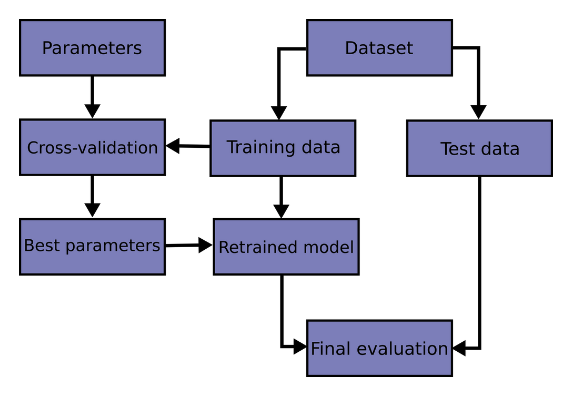

*Figure 1: Cross-validation workflow.*

### [ **Exercice 3** ]
<img src="Figures/eye_logo.png" width="75"/>

How would you design a validation-testing workflow for the problem of predicting the mass balance? How would you divide the different folds?

For an excellent introduction to cross-validation, as well as the different high-level function to implement it in `sklearn` models, checkout [this tutorial](https://scikit-learn.org/stable/modules/cross_validation.html). 

This notebook is up to you to define it. Choose a cross-validation approach, and use it in one of the machine learning models you chose from the previous notebook. Try to tune the hyperparameters as much as you can in cross-validation. In the end, once you are sure you cannot improve performance anymore, load the **test** dataset that we saved in the previous notebook, and assess the final model performance with your selected hyperparameters.

### Happy coding! 

## 4.2 Hyperparameter selection in cross-validation for a chosen model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
# read dataset
df_all = pd.read_csv('Data/df_all.csv', index_col=['rgi_id', 'period'])

In [4]:
# split dataset into train and test:
glaciers_ids_all = np.unique(df_all.index.get_level_values(0).values)

glacier_train, glacier_test = train_test_split(glaciers_ids_all, 
                                               train_size=0.7,
                                               test_size=0.3)

df_train_all = df_all.loc[glacier_train]
df_test = df_all.loc[glacier_test]
df_train_all.shape, df_test.shape

# save test data set for later:
df_test.to_csv('Data/df_test.csv')

In [5]:
# features to drop:
features_to_drop = ['dmdtda', 'err_dmdtda', 'target_id']

df_train_all_X = df_train_all.drop(features_to_drop, axis=1)
df_train_all_y = df_train_all[['dmdtda']]

X_train_all, y_train_all = df_train_all_X.values, df_train_all_y.values

In [6]:
# Function for plot the model:

def plot_prediction(y1, y2, n_toplot=10**10):
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    plt.figure(figsize=(8,8))
    plt.title("Model Evaluation", fontsize=17)
    plt.ylabel('Modeled SMB (m.w.e)', fontsize=16)
    plt.xlabel('Reference SMB (m.w.e)', fontsize=16)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=20)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    plt.colorbar(sc) 
    lineStart = -2.5
    lineEnd = 1.5
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()

### Chosen model: Ensemble of trees

In [7]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")

In [8]:
model = 'random forest'
#model = 'gradient boosting'

if model == 'gradient boosting':

    params = {
        "n_estimators": 300,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.1,
        "loss": 'huber', #"squared_error",
        "validation_fraction": 0.2
    }
    reg_ensemble = ensemble.GradientBoostingRegressor(**params)
    
elif model == 'random forest':
    
    params = {
        "n_estimators": 400,
        "max_depth": 14,
        "min_samples_split": 5,
        "criterion": "friedman_mse",
        "max_features": 15,
        "n_jobs": -2
    }
    reg_ensemble = ensemble.RandomForestRegressor(**params)

In [9]:
parameters_RF = {"max_depth": np.arange(12,14,1), 
                 'n_estimators': np.arange(300,900,100),
#                 'max_features': np.arange(15,18,1),
#                 "min_samples_split": np.arange(10,50,10),
             }
parameters_GB = {'n_estimators': np.arange(100,300,100),
              'max_depth': np.arange(4,6,1), 
              'min_samples_split': np.arange(4,6,1)
             }

In [10]:
clf = GridSearchCV(reg_ensemble, parameters_RF)

In [11]:
%%time
clf.fit(X_train_all, y_train_all)

CPU times: user 1min 2s, sys: 3.1 s, total: 1min 5s
Wall time: 10min 49s


GridSearchCV(estimator=RandomForestRegressor(criterion='friedman_mse',
                                             max_depth=14, max_features=15,
                                             min_samples_split=5,
                                             n_estimators=400, n_jobs=-2),
             param_grid={'max_depth': array([12, 13]),
                         'n_estimators': array([300, 400, 500, 600, 700, 800])})

In [13]:
print(clf.best_params_)

{'max_depth': 13, 'n_estimators': 600}


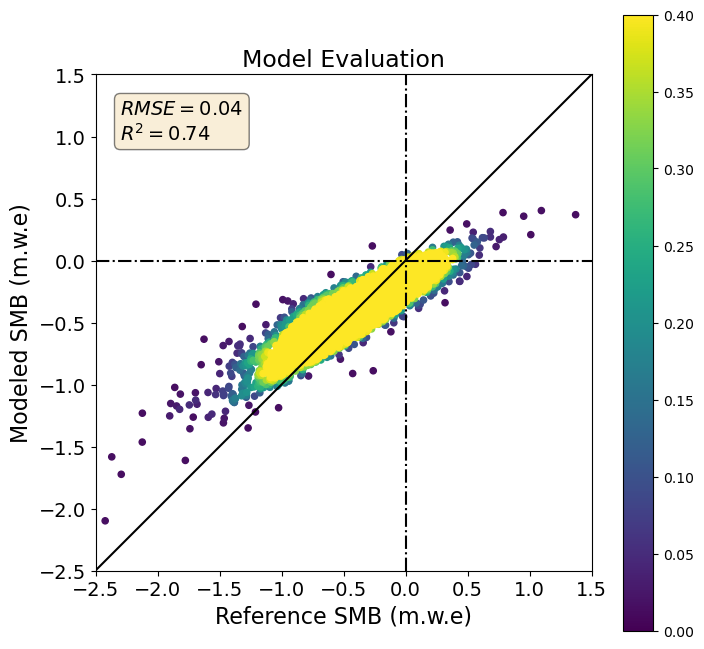

In [14]:
plot_prediction(y_train_all, clf.predict(X_train_all), n_toplot = 5000)

## 4.3 Testing the final model